# Convolution of astronomical data

The [astropy.convolution](https://docs.astropy.org/en/stable/convolution/) sub-package provides convolution functions that can correctly handle NaN/missing values, and also provides common convolution kernels and functionality to create custom kernels. Packages such as SciPy also include functionality for convolution (see e.g. [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html)), but these do not typically treat NaN/missing values properly.


<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span> Objectives</h2>
</div>


<div class="panel-body">

<ul>
<li>Use built-in kernels and understand discretization options</li>
<li>Use NaN-friendly convolution functions</li>
</ul>

</div>

</section>


## Documentation

This notebook only shows a subset of the functionality in astropy.convolution. For more information about the features presented below as well as other available features, you can read the
[astropy.convolution documentation](https://docs.astropy.org/en/stable/convolution/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

## Convolution kernels

A number of convolution kernels are provided by default - these are classes that support several options for discretization onto a pixel grid. An example of such a kernel is [Gaussian2DKernel](https://docs.astropy.org/en/stable/api/astropy.convolution.Gaussian2DKernel.html#astropy.convolution.Gaussian2DKernel):

In [2]:
from astropy.convolution import Gaussian2DKernel

In [3]:
kernel1 = Gaussian2DKernel(2)

Kernels have a ``.array`` attribute that can be used to access the discretized values:

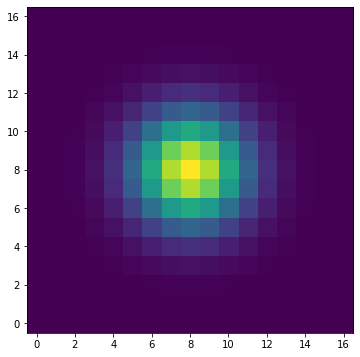

In [4]:
plt.imshow(kernel1)

By default, the kernel is discretized by sampling the values of the Gaussian (or whatever kernel function is used) at the center of each pixel. However this can cause issues if the kernel is not very well resolved by the grid:

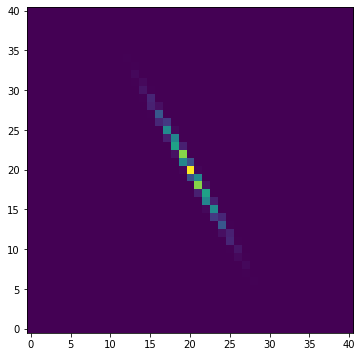

In [5]:
from astropy import units as u
kernel2 = Gaussian2DKernel(x_stddev=0.3, y_stddev=5, theta=30 * u.deg)
plt.imshow(kernel2.array)

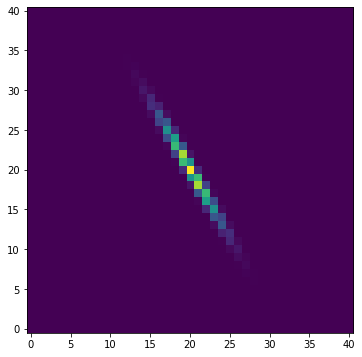

In [6]:
kernel3 = Gaussian2DKernel(x_stddev=0.3, y_stddev=5, theta = 30 * u.deg, mode='oversample')
plt.imshow(kernel3.array)

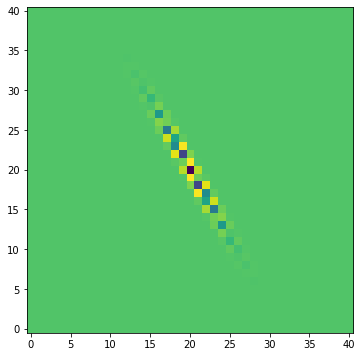

In [7]:
plt.imshow(kernel3.array - kernel2.array)

A list of available kernels can be found [in the documentation](https://docs.astropy.org/en/stable/convolution/kernels.html#available-kernels). If you are interested in constructing your own kernels, you can make use of any astropy model, and make use of the [Model1DKernel](http://docs.astropy.org/en/stable/api/astropy.convolution.Model1DKernel.html#astropy.convolution.Model1DKernel) and [Model2DKernel](http://docs.astropy.org/en/stable/api/astropy.convolution.Model1DKernel.html#astropy.convolution.Model2DKernel)  classes.

## Convolution functions

The two main convolution functions provided are [convolve](https://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html#astropy.convolution.convolve) and [convolve_fft](https://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html#astropy.convolution.convolve_fft) - the former implements direct convolution (more efficient for small kernels), and the latter FFT convolution (more efficient for large kernels)

In [8]:
from astropy.convolution import convolve, convolve_fft

To understand how the NaN treatment differs from SciPy, let's take a look at a simple example:

In [9]:
import numpy as np
data = [1, 2, np.nan, 4, 5]
kernel = [0.5, 1, 0.5]

In [10]:
from scipy.ndimage import convolve as scipy_convolve

In [11]:
scipy_convolve(data, kernel)

array([2.5, nan, nan, nan, 9.5])

In [12]:
convolve(data, kernel)

array([1.        , 1.66666667, 3.        , 4.33333333, 3.5       ])

In short, the way this works is, prior to the convolution, to replace NaNs with the average of nearby pixels weighted by the kernel. The astropy convolution functions can work for data in 1-, 2- and 3-dimensions.

We can take a look at an example for an image, using one of the FITS images used previously:

In [13]:
from astropy.io import fits
gaia_map = fits.getdata('data/LMCDensFits1k.fits')

This image doesn't contain any NaN values, but we can sprinkle some NaN values throughout with:

In [14]:
np.random.random((750, 1000)) > 0.999

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
gaia_map[np.random.random((750, 1000)) > 0.999] = np.nan

In [16]:
gaia_map[10:20, 500:511]

array([[ 8.,  3.,  9.,  4.,  5.,  5.,  3.,  3.,  5.,  9.,  8.],
       [ 3.,  3.,  3.,  5.,  9.,  4.,  7.,  4.,  5.,  8.,  3.],
       [ 5.,  4.,  3.,  6.,  2.,  4.,  5.,  4.,  6.,  6.,  6.],
       [ 5.,  8.,  1.,  4.,  3.,  6.,  8.,  6.,  8.,  7.,  4.],
       [ 7.,  4.,  4.,  4.,  5.,  4.,  5.,  6.,  8.,  4.,  6.],
       [ 8.,  3.,  2.,  7.,  5.,  4.,  7.,  3.,  4.,  4.,  3.],
       [ 2.,  5.,  4.,  2.,  4.,  5.,  4.,  2.,  3.,  7.,  7.],
       [ 8.,  4.,  2.,  4.,  7.,  1.,  2., 13.,  6.,  8.,  4.],
       [ 4.,  9., 12.,  6.,  6.,  4.,  5.,  4.,  6.,  2.,  5.],
       [ 6.,  5.,  5.,  7.,  3.,  2.,  5.,  4.,  3.,  4.,  5.]])

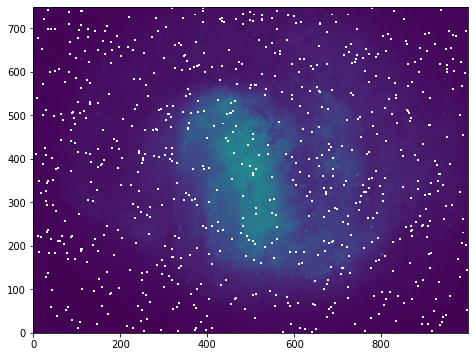

In [17]:
plt.imshow(gaia_map)

Let's construct a small Gaussian kernel:

In [18]:
gauss = Gaussian2DKernel(3)

And we can now compare the convolution from scipy.ndimage and astropy.convolution:

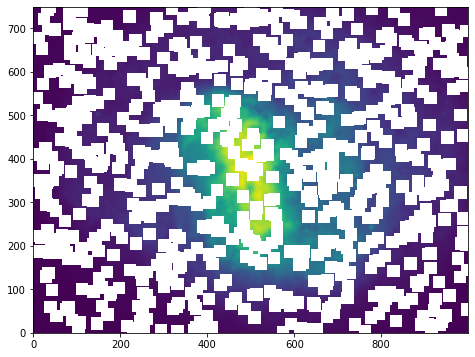

In [19]:
plt.imshow(scipy_convolve(gaia_map, gauss.array))

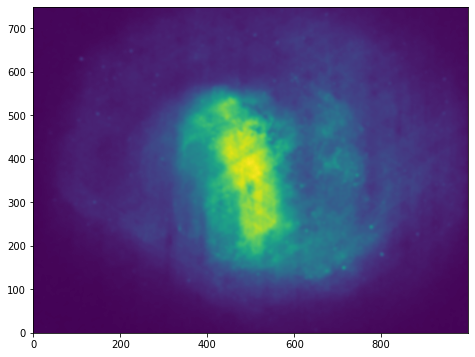

In [20]:
plt.imshow(convolve(gaia_map, gauss))


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<p>Using a simple 1D dataset as done above, can you determine whether the kernel is automatically normalized by default? How can you change this behavior? And how does this compare to SciPy's convolve function?</p>

</div>

</section>


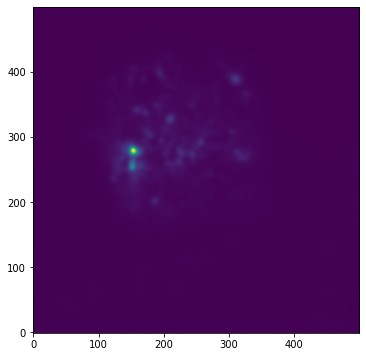

In [22]:
#not required to 100%. create 3 examples of convolution

ISSA = fits.getdata('data/ISSA_100_LMC.fits')
plt.imshow(convolve(ISSA, gauss))

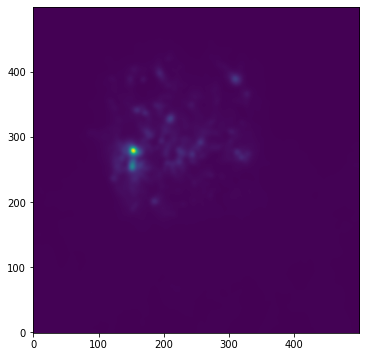

In [23]:
plt.imshow(scipy_convolve(ISSA, gauss.array))

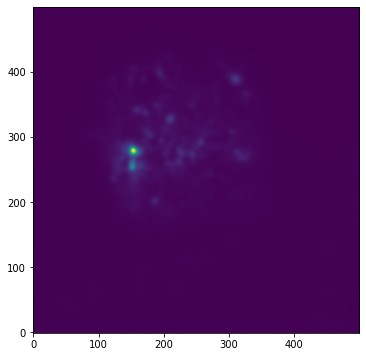

In [24]:
plt.imshow(convolve(ISSA, gauss))

<center><i>This notebook was originally written by <a href="https://aperiosoftware.com/">Aperio Software Ltd</a> and modified by Brigitta Sipőcz. &copy; 2019-2021 and is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License (CC BY 4.0)</a></i></center>

![cc](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)